In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pylab as plt
import numpy as np
import torch
import swyft.lightning as sl

In [3]:
class Simulator(sl.Simulator):
    def __init__(self, bounds = None):
        super().__init__()
        self.on_after_forward = sl.to_numpy32
        
    def forward(self, trace):
        z = trace.sample('z', np.random.rand, 3)
        x = trace.sample('x', lambda z: z + np.random.randn(3)*0.02, z)

In [4]:
class Network(sl.SwyftModule):
    def __init__(self):
        super().__init__(lr=1e-3)
        self.classifier = sl.RatioEstimatorMLP1d(3, 3, hidden_features = 256, dropout = 0.1)
        
    def forward(self, x, z):
        x = x['x']
        z = z['z']
        ratios_z = self.classifier(x, z)
        return dict(z = ratios_z)

In [5]:
simulator = Simulator()
noise_hook = simulator.get_resampler(['x'])

In [6]:
shapes, dtypes = simulator.get_shapes_and_dtypes()
zs = sl.ZarrStore("./03-minimal-zarr.zarr")
zs.init(10000, 32, shapes = shapes, dtypes = dtypes)
zs.simulate(simulator, batch_size = 500)

In [7]:
dl = zs.get_dataloader(num_workers = 3, batch_size = 128, on_after_load_sample = noise_hook)

In [8]:
samples = zs.get_sample_store()
datamodule = sl.SwyftDataModule(store = samples, batch_size = 128)

Deprecation warning: Use dataloaders directly rathe than this data module for transparency.


In [9]:
trainer = sl.SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 3, **sl.tensorboard_config(name = '01-minimal-example', version=None))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [10]:
network = Network()

In [11]:
trainer.fit(network, dl, dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                | Params
---------------------------------------------------
0 | classifier | RatioEstimatorMLP1d | 800 K 
---------------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.201     Total estimated model params size (MB)


Epoch 0: : 77it [00:01, 56.78it/s, loss=1.16, v_num=147]              
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 0: : 80it [00:01, 47.89it/s, loss=1.16, v_num=147]
Epoch 0: : 95it [00:01, 53.39it/s, loss=1.16, v_num=147]
Epoch 0: : 110it [00:01, 58.27it/s, loss=1.16, v_num=147]
Epoch 0: : 125it [00:02, 62.29it/s, loss=1.16, v_num=147]
Epoch 0: : 140it [00:02, 66.21it/s, loss=1.16, v_num=147]
Epoch 0: : 155it [00:02, 68.30it/s, loss=1.16, v_num=147, val_loss=1.150]
Epoch 1: : 77it [00:01, 55.78it/s, loss=1.07, v_num=147, val_loss=1.150] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1: : 90it [00:01, 51.20it/s, loss=1.07, v_num=147, val_loss=1.150]
Epoch 1: : 105it [00:01, 55.50it/s, loss=1.07, v_num=147, val_loss=1.150]
Epoch 1: : 120it [00:02, 59.92it/s, loss=1.07, v_num=147, val_loss=1.150]
Epoch 1: : 135it [00:02, 64.08it/s, loss=1.07, v_num=147, val_loss=1.150]
Epoch 1: : 150it [00:02, 67.78it/s, loss=1.07, v_num=147, val_loss=1.150]


In [12]:
trainer.test(network, datamodule, ckpt_path = 'best')

Restoring states from the checkpoint path at ./lightning_logs/01-minimal-example/version_147/checkpoints/epoch=1-step=153.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/01-minimal-example/version_147/checkpoints/epoch=1-step=153.ckpt
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing:  80%|███████▉  | 63/79 [00:00<00:00, 153.83it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'hp/JS-div': 1.101487398147583, 'hp/KL-div': -7.310939788818359}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 79/79 [00:00<00:00, 153.00it/s]


[{'hp/JS-div': 1.101487398147583, 'hp/KL-div': -7.310939788818359}]

In [13]:
x0 = [0.3, 0.5, 0.7]
prior_samples = simulator.sample(1000000, targets = ['z'])

In [14]:
predictions = trainer.infer(network, {'x': torch.tensor(x0)}, prior_samples.get_dataloader(batch_size = 1024))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting:   9%|▊         | 84/977 [00:00<00:13, 66.47it/s]

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:174: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting: 100%|██████████| 977/977 [00:15<00:00, 58.70it/s]


In [15]:
post_samples = predictions.sample(100000)

0.022248205
0.018345581
0.022495562


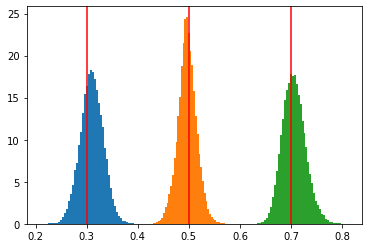

In [16]:
import pylab as plt
for i in range(3):
    s = post_samples['z'][:,i].numpy()
    print(s.std())
    plt.hist(s, bins = 50, density=True);
    plt.axvline(x0[i], color='r')